# Crossword Local Search

## 概要
このノートブックではクロスワード(スケルトンパズル)自動生成ツールおよびそれらの可視化について紹介します。

***

## 入力データ・実行パラメータ設定
入力データを指定し、各種実行パラメータの設定を行います。
各パラメータは以下の通り：
  * `fpath`      : 入力データ(単語リスト)のファイルパス
  * `width`          : 盤面の大きさ(横)
  * `height`          : 盤面の大きさ(縦)
  * `randomSeed`       : シード値
  * `withWeight` : 辞書に重みを付すかどうか(bool)
  * `puzzleTitle` : パズルのタイトル（デフォルトは「スケルトンパズル」）

In [1]:
fpath = f"../dict/typhoon.txt" # countries hokkaido animals kotowaza birds dinosaurs fishes sports pokemon typhoon
width = 15
height = 15
randomSeed = 6
withWeight = False
puzzleTitle = "台風パズル" # default:スケルトンパズル

***

## Import
必要なライブラリをimportし, 乱数のシード値および, 日本語フォントの指定などを行う：

In [2]:
import os
import copy
import datetime
import time
import math
import itertools
import unicodedata
import collections
import pickle

import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
#%matplotlib inline

fp = FontProperties(fname="fonts/SourceHanCodeJP.ttc", size=14)
np.random.seed(seed = randomSeed)
start = time.time()

***

## クラス宣言
本プログラムで使用するクラスを定義する。  
見やすさのため、クラスメソッドやインスタンスメソッドは後から定義し、`setattr`関数で属性として追加します。


### Puzzle クラス
解となるスケルトンパズルそのものを表すクラス。
メンバ変数は以下の通り：
  * width : 盤面の大きさ(横)
  * height : 盤面の大きさ(縦)
  * totalWeight : 単語の重みの合計
  * puzzleTitle：パズルのタイトル(str)
  * enable : 配置禁止マスを保持した2次元(width*height)配列
  * cell : パズルの解を保存する2次元(width*height)配列
  * cover : セル上の文字数を保持する2次元(width*height)配列
  * coverDFS : 連結成分を探すときに使われる2次元(width*height)配列
  * usedWords : 解として使われた単語の一覧
  * usedPlcIdx : 解として使われた(後に定義する)Placeable配列上の添え字一覧
  * solSize : パズルに配置されている単語の数
  * history : 単語増減の履歴
  * historyIdx : 現在参照している履歴番号
  * log：目的関数値の履歴
  * epoch : 初期解から局所探索した回数
  * initSol : 初期解が作られたかどうか(bool)
  * initSeed：初期解作成開始時点のseed値
  * dic：Dictionaryオブジェクト(後述)
  * plc：Placeableオブジェクト(後述)
  * objFunc：ObjectiveFunctionオブジェクト(後述)
  * optimizer：Optimizerオブジェクト(後述)

In [3]:
class Puzzle():
    def __init__(self, width, height, puzzleTitle="スケルトンパズル", msg=True):
        self.width = width
        self.height = height
        self.totalWeight = 0
        self.puzzleTitle = puzzleTitle
        self.enable = np.ones(width*height, dtype = "bool").reshape(height,width)
        self.cell = np.full(width*height, "", dtype = "unicode").reshape(height,width)
        self.cover = np.zeros(width*height, dtype = "int64").reshape(height,width)
        self.coverDFS = np.zeros(width*height, dtype = "int64").reshape(height,width)
        self.usedWords = np.full(width*height, "", dtype = "U%d" % max(width,height))
        self.usedPlcIdx = np.full(width*height, -1, dtype = "int64")
        self.solSize = 0
        self.history = []
        self.historyIdx = 0
        self.log = None
        self.epoch = 0
        self.initSol = False
        self.initSeed = None
        self.dic = None
        self.plc = None
        self.objFunc = None
        self.optimizer = None

        ## Message
        if msg == True:
            print("Puzzle object has made.")
            print(f" - title       : {self.puzzleTitle}")
            print(f" - width       : {self.width}")
            print(f" - height      : {self.height}")
            print(f" - cell' shape : (width, height) = ({self.cell.shape[0]},{self.cell.shape[1]})")
            
    def __str__(self):
        return self.puzzleTitle

In [4]:
sample_puzzle = Puzzle(width, height, puzzleTitle)

Puzzle object has made.
 - title       : 台風パズル
 - width       : 15
 - height      : 15
 - cell' shape : (width, height) = (15,15)


### Dictionary クラス
入力した単語リストを整理して保持するクラス。
メンバ変数は以下の通り：
  * fpath : 入力データのファイルパス
  * size : 辞書の大きさ(単語数)
  * dictType : 辞書のタイプ("English"/"Japanese")
  * data : 入力データ配列

In [5]:
class Dictionary():
    def __init__(self, fpath, msg=True):
        self.fpath = fpath
        self.name = os.path.basename(fpath)[:-4]
        print("Dictionary object has made.")
        ## Read
        print(" - READING DICTIONARY...")
        file = open(self.fpath, 'r', encoding='utf-8')
        self.data = file.readlines()
        file.close()
        # Get a size of dictionary
        self.size = len(self.data)
        # Check dictionary type(English/Japanese)
        uniName = unicodedata.name(self.data[0][0])[0:10]
        if "HIRAGANA" in uniName or "KATAKANA" in uniName:
            self.dictType = "Japanese"
        elif "LATIN" in uniName:
            self.dictType = "English"
            #self.data = [s.upper() for s in self.data]
        elif "CJK" in uniName:
            self.dictType = "Kanji"

        # Remove "\n"
        def removeNewLineCode(word):
            line = word.rstrip("\n").split(" ")
            if len(line) == 1:
                line.append(0)
            line[1] = int(line[1])
            return dict(zip(["word", "weight"], line))
        self.data = list(map(removeNewLineCode, self.data))

        ## Message
        if msg == True:
            print(f" - file path         : {self.fpath}")
            print(f" - dictionary size   : {self.size}")
            print(f" - dictionary type   : {self.dictType}")
            print(f" - top of dictionary : {self[0]}")

    def __getitem__(self, i):
        return self.data[i]
    
    def __str__(self):
        return self.name
    
    def __len__(self):
        return self.size

In [6]:
sample_dic = Dictionary(fpath)

Dictionary object has made.
 - READING DICTIONARY...
 - file path         : ../dict/typhoon.txt
 - dictionary size   : 140
 - dictionary type   : English
 - top of dictionary : {'word': 'Damrey', 'weight': 0}


無駄な計算を減らすため、他のどの単語とも接続(クロス)できない単語は辞書からあらかじめ削除しておきます。  
`Dictionary`クラスに`deleteUnusableWords`メソッドを実装します：

In [7]:
def deleteUnusableWords(self, msg=True):
    """
    This method checks words in the dictionary and erases words that can not cross any other words.
    """
    self.removedWords = []
    mergedWords = "".join([d.get("word") for d in self.data])
    counts = collections.Counter(mergedWords)
    for word in self.data[:]:
        charValue = 0
        for char in set(word["word"]):
            charValue += counts[char]
        if charValue == len(word["word"]):
            self.removedWords.append(word)
            self.data.remove(word)
            self.size -= 1
            if msg:
                print(f"'{word['word']}' can not cross with any other words")
setattr(Dictionary, "deleteUnusableWords", deleteUnusableWords)

In [8]:
sample_dic.deleteUnusableWords()

これで、他の単語とクロスしない単語を辞書から削除できました。  
削除された単語は`removedWords`プロパティから参照できます。

通常、辞書内の単語にはその重要性の指標として「重み」を付すことができますが、
重みなしの辞書を入力として与える場合は、簡単な計算を元に重みを自動計算させることができます。  
自動計算では、各単語に使用されるそれぞれの文字が、辞書内の全単語中で何回ずつ使用されたかをカウントし、  
単語内の各文字に対応するカウントの合計を重みとして設定します。  
例えば、辞書内の単語が
「アメリカ」「ロシア」「シリア」
だった場合、各文字の出現回数は
* ア：３回
* シ：２回
* リ：２回
* メ：１回
* カ：１回
* ロ：１回  

より、各単語は「アメリカ：７点」,「ロシア：６点」,「シリア：７点」となります。
`Dictionary`クラスに`calcWeight`メソッドを実装します：

In [9]:
def calcWeight(self, msg=True):
    """
    Calculate word weights in the dictionary.
    """
    mergedWords = "".join([d.get("word") for d in self.data])
    counts = collections.Counter(mergedWords)
    for word in self.data:
        for char in word["word"]:
            word["weight"] += counts[char]
            
    if msg:
        print("All weights are calculated.")
        print("TOP 5 characters")
        print(counts.most_common()[:5])
        print("TOP 5 words")
        print(sorted(self.data, key=lambda d:d["weight"], reverse=True)[:5])
setattr(Dictionary, "calcWeight", calcWeight)

In [10]:
if not withWeight:
    sample_dic.calcWeight()

All weights are calculated.
TOP 5 characters
[('a', 131), ('i', 78), ('n', 69), ('o', 53), ('u', 45)]
TOP 5 words
[{'word': 'Hinnamnor', 'weight': 536}, {'word': 'Malakas', 'weight': 488}, {'word': 'Shanshan', 'weight': 483}, {'word': 'Kalmaegi', 'weight': 477}, {'word': 'Yamaneko', 'weight': 476}]


### Placeable クラス
辞書内のすべての単語に対して、それぞれの単語が配置可能(placeable)な位置の一覧を作るクラス。  
これは`Puzzle`クラスと`Dictionary`クラスの両方の要素を用いて行われます。

配置可能な位置は、単語の先頭文字の座標で指定します。  
ここでは、パズルの左上を(0,0)、右上を(n,0)、左下を(0,n)、右下を(n,n)とします。  
例えば、大きさが5×5のパズル上に`Dictionary`クラスの5番目に格納された長さ4文字の単語「HOGE」を配置しようとした場合、配置可能な位置は
  * 横向きの場合：(0,0),(0,1),(0,2),(0,3)(0,4),(1,0),(1,1),(1,2),(1,3),(1,4)の10マス。
  * 縦向きの場合：(0,0),(1,0),(2,0),(3,0)(4,0),(0,1),(1,1),(2,1),(3,1),(4,1)の10マス。  
よって、配置する場合のパターンは全部で20通りになります。
詳しくは次の図をご参照ください。青が単語配置可能な位置、赤が配置不可能な位置を示します。

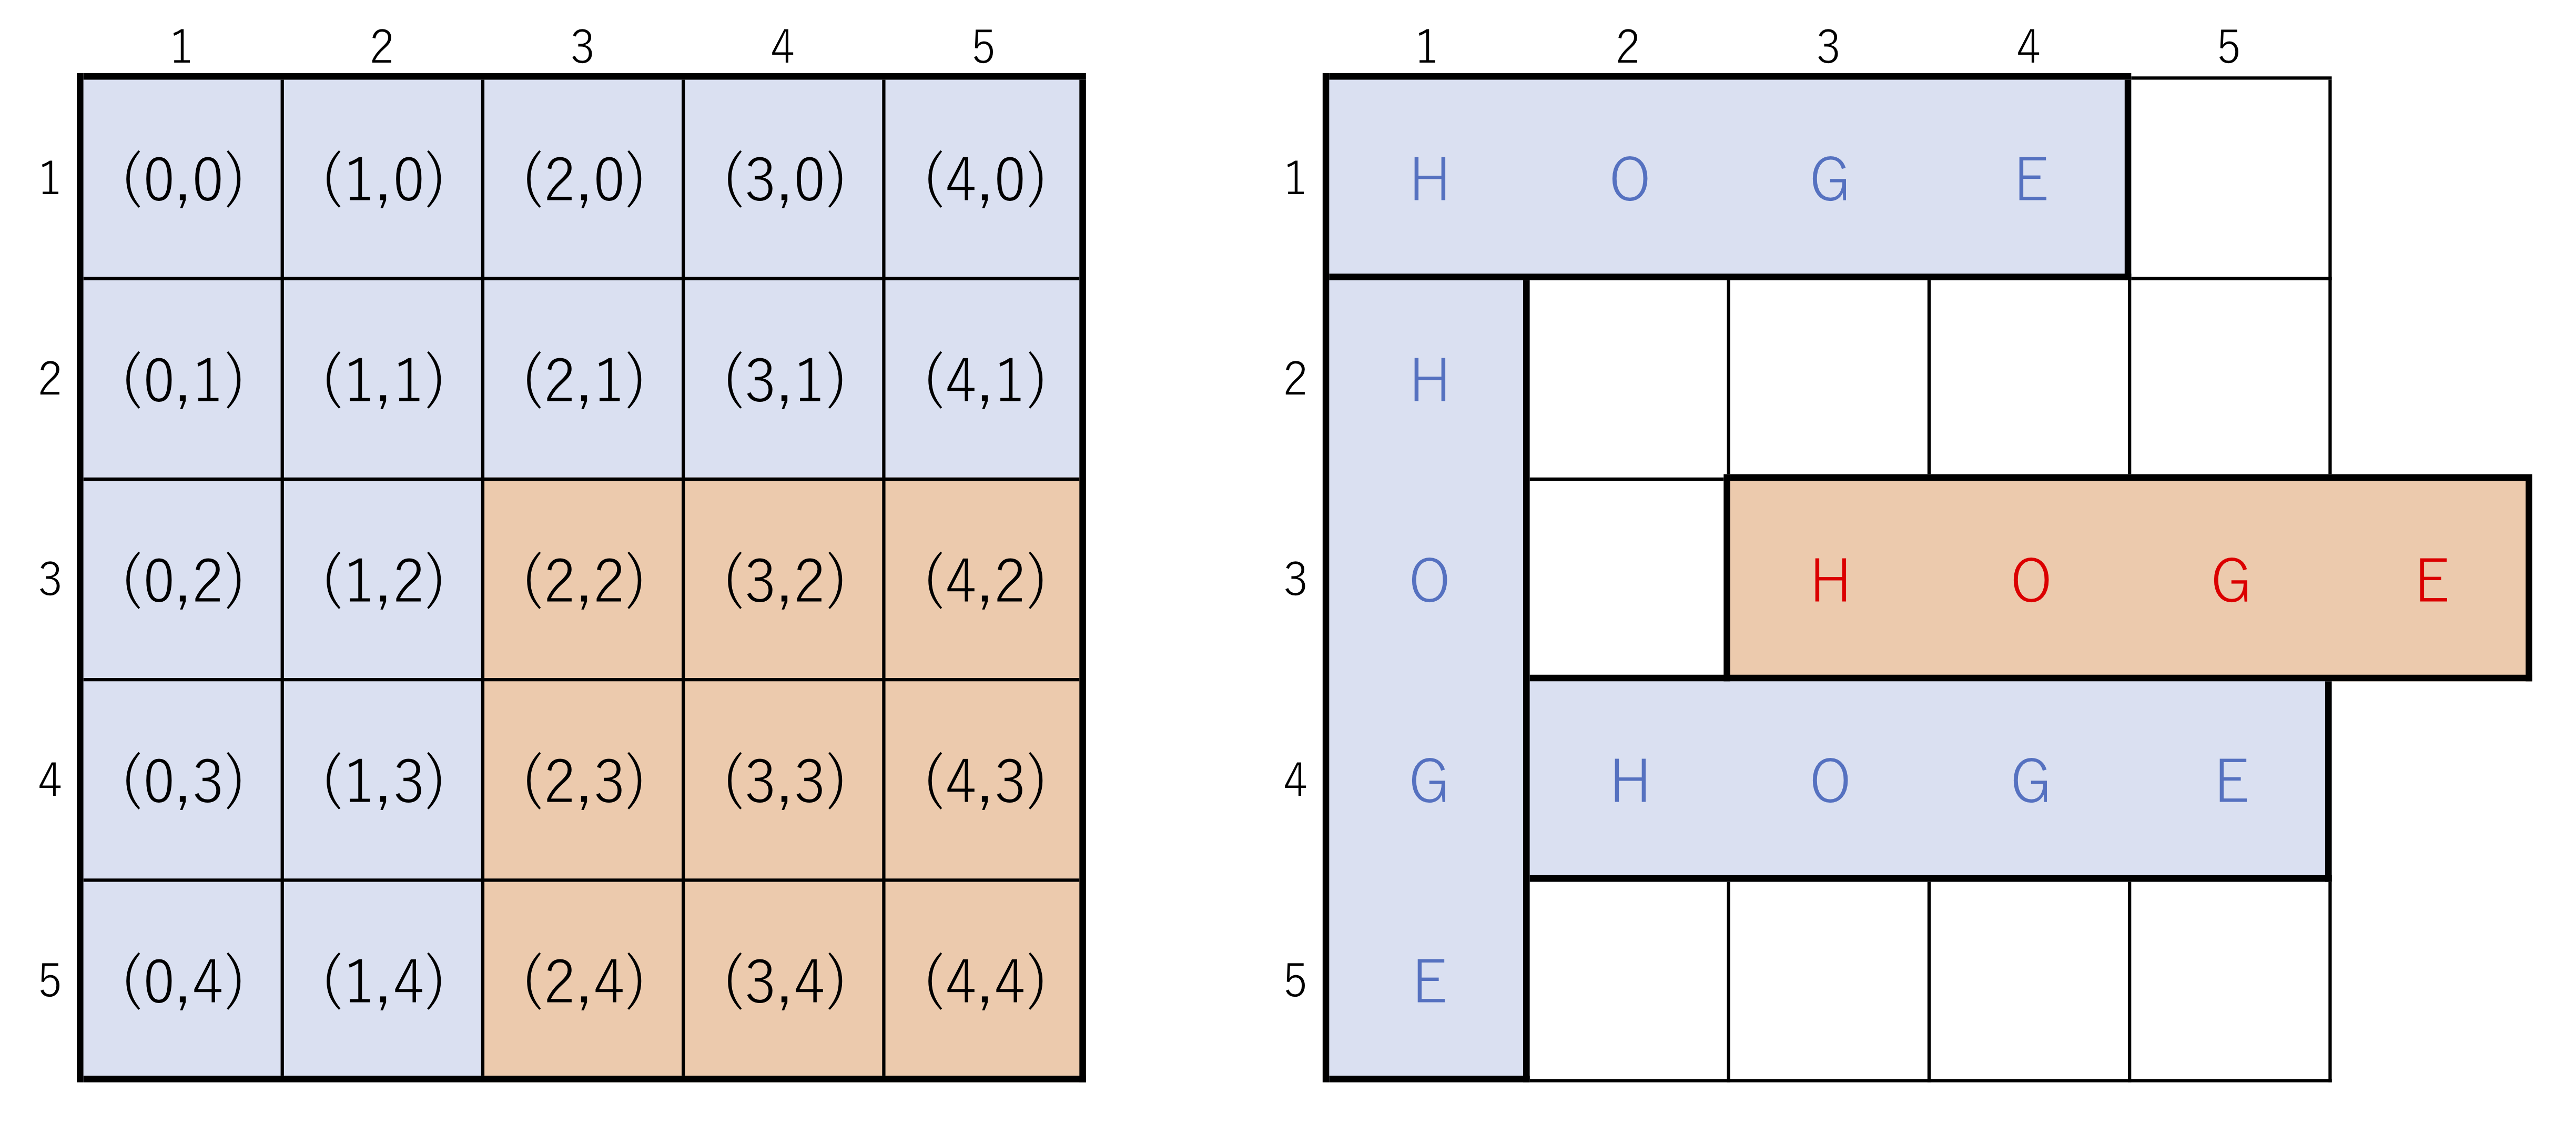

In [11]:
display(Image.open("fig/puzzles.png"))

これらの情報は次のフォーマットで整理されます：
  * k : 単語番号(辞書内の何番目の単語か)
  * div : 単語を置く向き(0: 縦, 1: 横)
  * j : 単語の先頭文字のx座標
  * i : 単語の先頭文字のy座標

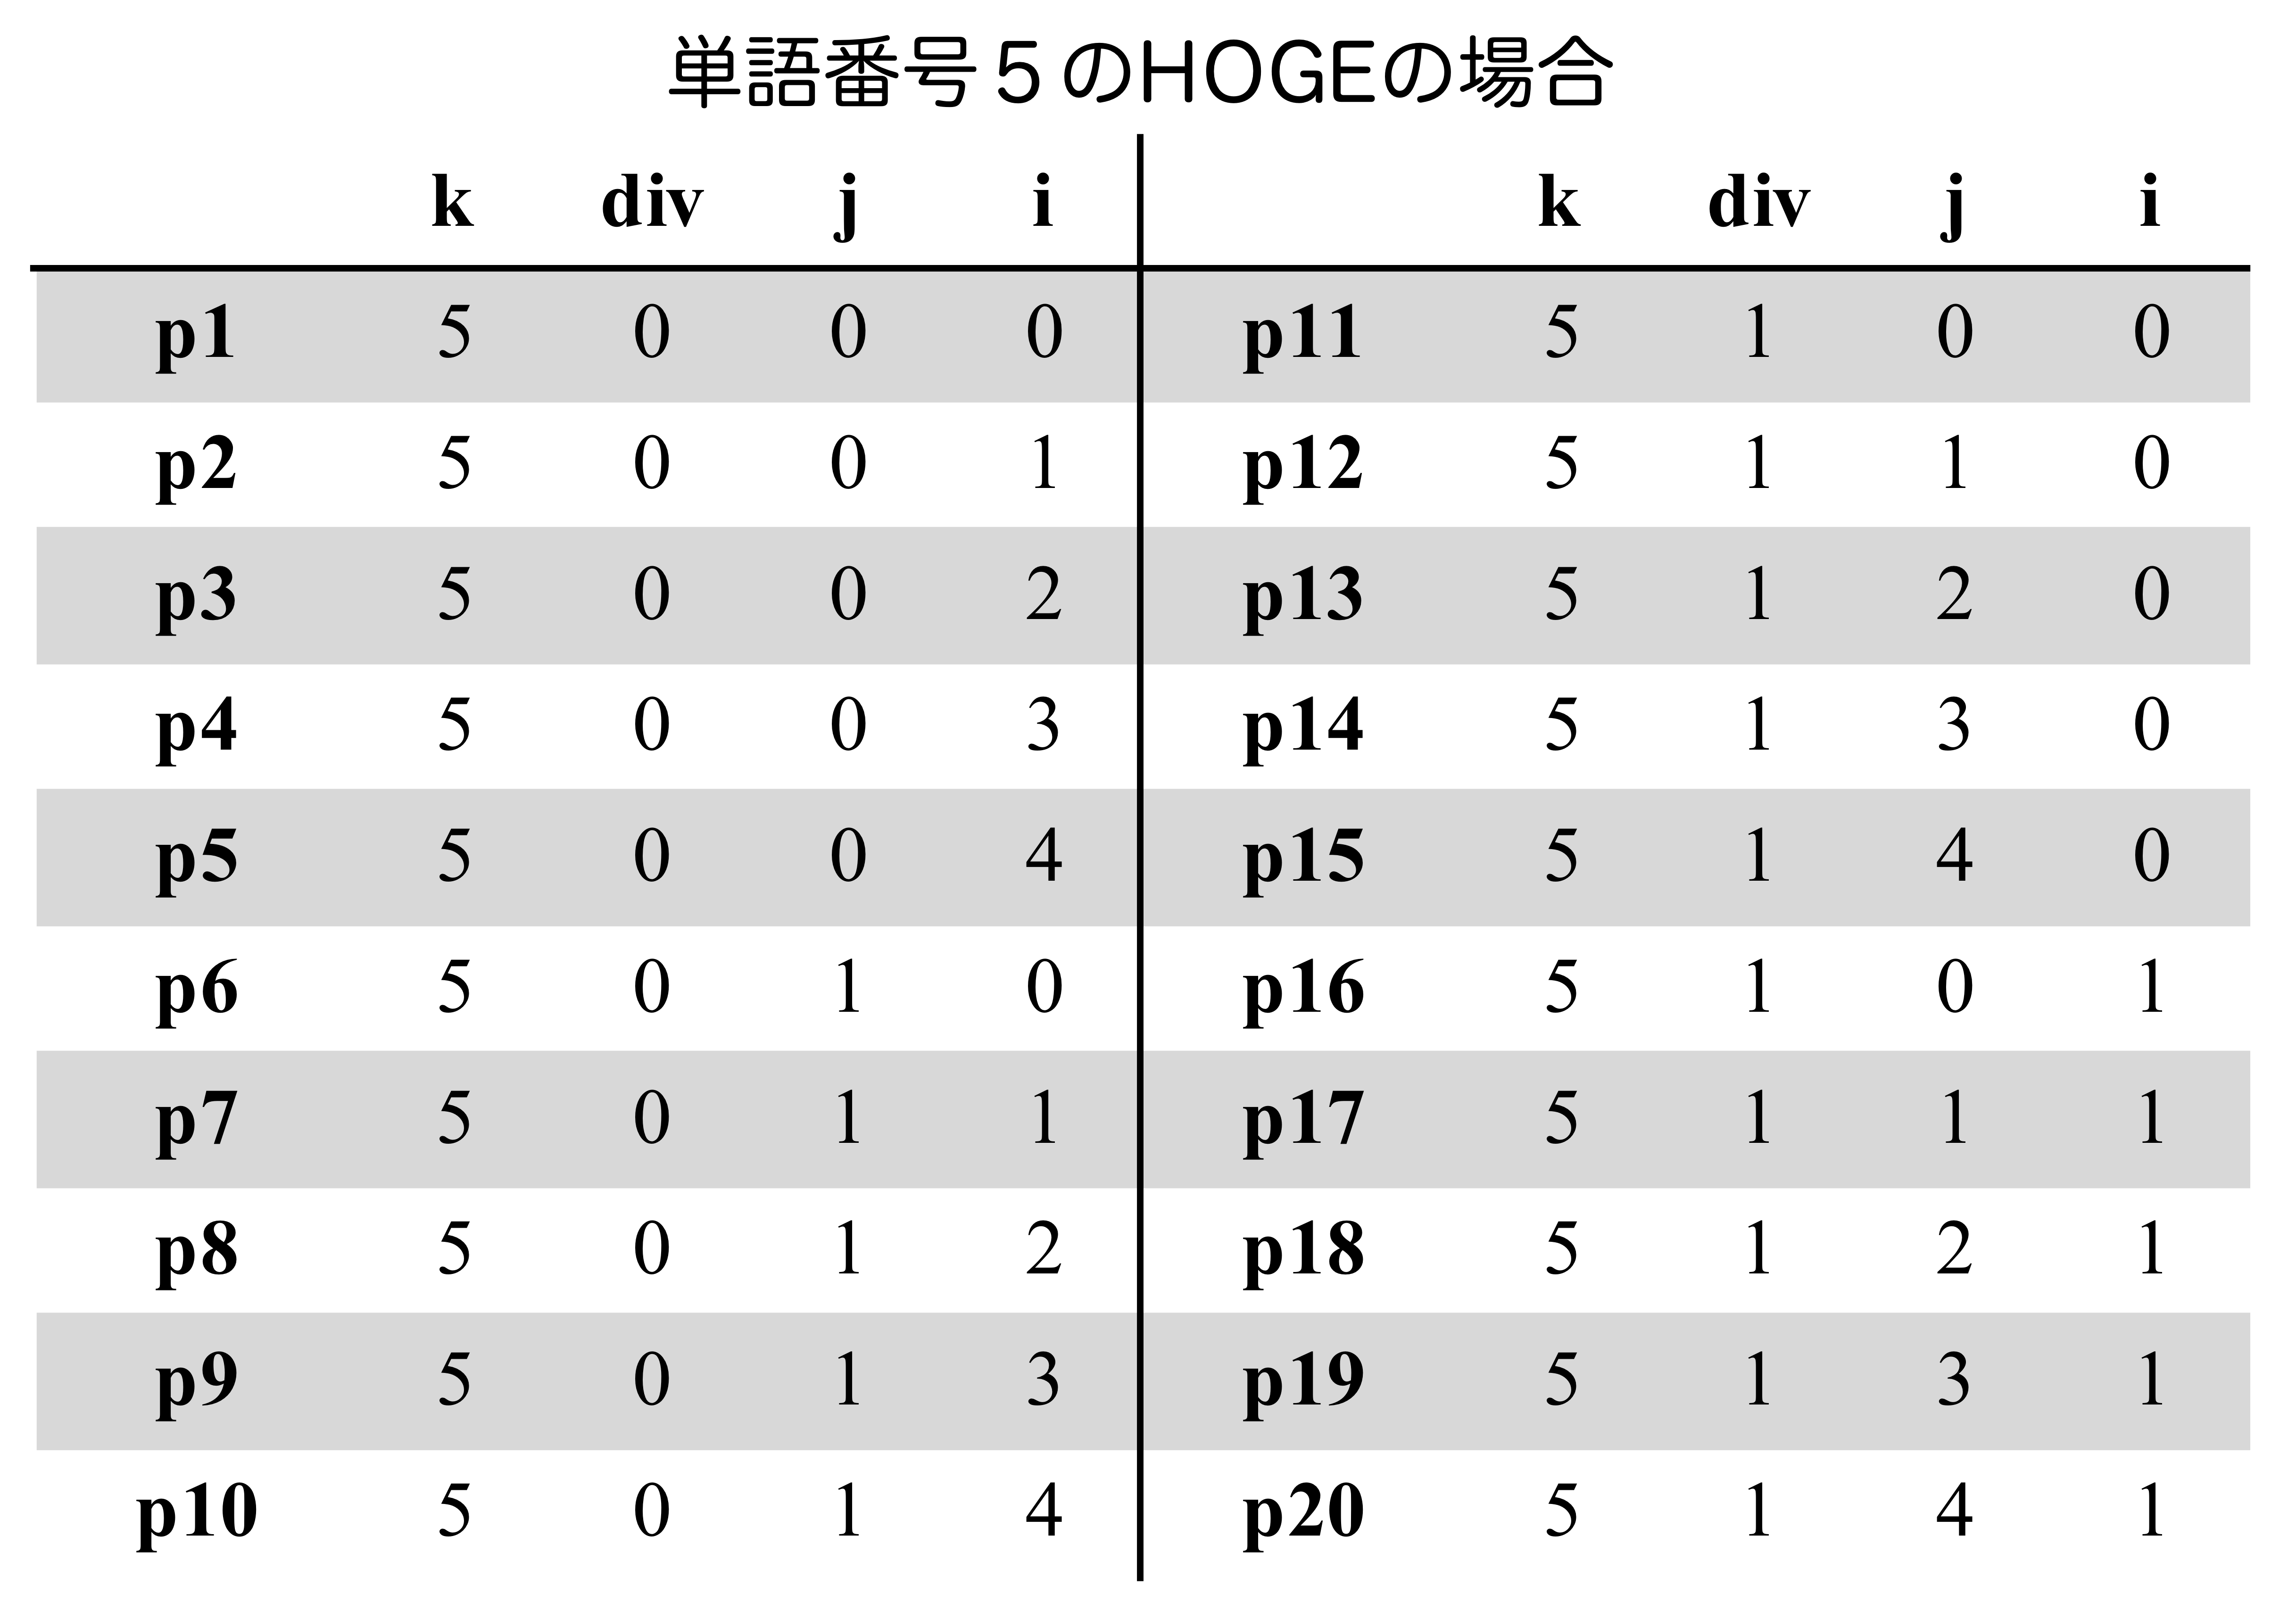

In [12]:
display(Image.open("fig/sample_placeable.png"))

メンバ変数は以下の通り：
  * size : Placeableオブジェクトの大きさ
  * width : 引数のパズルの横幅
  * height : 引数のパズルの縦幅
  * div : Placeable成分の文字列の方向
  * k : Placeable成分の文字の番号
  * i : Placeable成分のy方向の座標
  * j : Placeable成分のx方向の座標
  * invP : Placeableオブジェクトの逆写像

In [13]:
class Placeable():
    def __init__(self, puzzle, dic, msg=True):
        self.size = 0
        self.width = puzzle.width
        self.height = puzzle.height
        self.div = np.zeros(2*dic.size*self.width*self.height, dtype='int64')
        self.k = np.zeros(2*dic.size*self.width*self.height, dtype='int64')
        self.i = np.zeros(2*dic.size*self.width*self.height, dtype='int64')
        self.j = np.zeros(2*dic.size*self.width*self.height, dtype='int64')
        self.invP = np.zeros(2*dic.size*self.width*self.height, dtype='int64').reshape(2,self.height,self.width,dic.size)

        for div in range(2):
            for k in range(dic.size):
                if div == 0:
                    iMax = self.height - len(dic[k]['word']) + 1
                    jMax = self.width
                elif div == 1:
                    iMax = self.height
                    jMax = self.width - len(dic[k]['word']) + 1
                for i in range(iMax):
                    for j in range(jMax):
                        self.div[self.size] = div
                        self.k[self.size] = k
                        self.i[self.size] = i
                        self.j[self.size] = j
                        self.invP[div,i,j,k] = self.size
                        self.size += 1
        if msg == True:
            print("Placeable object has made.")
            print(f" - placeable size : {self.size}/{self.div.size}(max shape)") 
    def __len__(self):
        return self.size

In [14]:
sample_plc = Placeable(sample_puzzle, sample_dic)

Placeable object has made.
 - placeable size : 42060/63000(max shape)


### ObjectiveFunction クラス
生成したパズルは何らかの指標で定量的にその良し悪しを評価する必要があります。  
そのパズルの良し悪しの指標として、「目的関数」を定義します。  
目的関数はパズルの初期解が得られてから、そのパズルを改善していくために使われます。  
目的関数には様々な指標が考えられるため、それらを管理する`ObjectiveFunction`クラスを定義します：

In [15]:
class ObjectiveFunction():
    def __init__(self, msg=True):
        self.flist = [
            "totalWeight",
            "solSize",
            "crossCount",
            "fillCount",
            "maxConnectedEmptys"
        ]
        self.registeredFuncs = []
        if msg == True:
            print("ObjectiveFunction object has made.")
    def __len__(self):
        return len(self.registeredFuncs)
    def getFuncs(self):
        return self.registeredFuncs

In [16]:
objFunc = ObjectiveFunction()

ObjectiveFunction object has made.


`flist`は後ほど実装する目的関数名をリスト化したものです。`ObjectiveFunction`クラスについての詳しい説明と実装は後ほど行われます。

### Optimizer クラス
目的関数を指標にパズルを改善していく際、どのような手法で最適化していくのかも重要なカギになります。  
この種の問題は「離散最適化問題(組み合わせ最適化)」と呼ばれ、巡回セールスマン問題などと近い分類に当たります。この手の問題で使われる最適化手法は「局所探索法」や「焼きなまし法」などが用いられます。  
最適化手法はアイデア次第で様々なものが考えられるため、これら管理する`Optimizer`クラスを定義しておきましょう：

In [17]:
class Optimizer():
    def __init__(self, msg=True):
        self.methodList = ["localSearch", "iterativeLocalSearch"]
        self.method = ""
        if msg == True:
            print("Opimizer object has made.")

In [18]:
optimizer = Optimizer()

Opimizer object has made.


`Optimizer`クラスについての詳しい説明と実装は後ほど行われます。  
また、`ObjectiveFunction`オブジェクトと`Optimizer`オブジェクトは同時に`Puzzle`オブジェクトにコンパイルすることで、`Puzzle`オブジェクトから呼び出しが可能になります。  
目的関数と最適化手法をパズルにコンパイルするための`compile`メソッドも後ほど実装します。

***
## パズル生成
それでは、実際にパズルを生成していきます。  
まずは、`placeable`オブジェクトから何らかの単語とその配置可能位置をランダムに取得し、パズルの盤面単語を一つ配置します。  
さらにランダムサンプリングを行い、取得した単語とその配置可能位置が盤面上の単語とスケルトンパズルのルールに従って接続できる場合は、その単語を盤面に配置します。  
この作業を反復し、どの単語をどの置き方にしても盤面上に乗らなくなった時、反復を終了します。

そのために、単語を盤面上に乗せる`add`メソッドを`Puzzle`クラスに追加します。  
ただしその前に、`add`メソッドで指定した単語と位置が、盤面上にスケルトンパズルのルールに従って配置可能かどうかをBoolianで返す`isEnabledAdd`メソッドを定義します：

In [19]:
### isEnabledAdd
def isEnabledAdd(self, div, i, j, word, wLen):
    """
    This method determines if a word can be placed
    """
    # If 0 words used, return True
    if self.solSize == 0:
        return True

    # If the same word is in use, return False
    if np.any(self.usedWords == word):
        return False

    # If the word does not fit in the puzzle, return False
    if div == 0 and i+wLen > self.height:
        return False
    if div == 1 and j+wLen > self.width:
        return False

    # US/USA, DOMINICA/DOMINICAN probrem
    if div == 0:
        emptys = self.cell[i:i+wLen, j] == ""
        if np.all(emptys == True) or np.any(self.enable[i:i+wLen, j] == False) or np.all(emptys == False):
            return False
    if div == 1:
        emptys = self.cell[i, j:j+wLen] == ""
        if np.all(emptys == True) or np.any(self.enable[i, j:j+wLen] == False) or np.all(emptys == False):
            return False

    # Judge whether correct intersection
    where = np.where(emptys == False)[0]
    if div == 0:
        jall = np.full(where.size, j, dtype = "int64")
        if np.any(self.cell[where+i, jall] != np.array(list(word))[where]):
            return False
    if div == 1:
        iall = np.full(where.size, i, dtype = "int64")
        if np.any(self.cell[iall, where+j] != np.array(list(word))[where]):
            return False

    # If neighbor cells are filled except at the intersection, return False
    where = np.where(emptys == True)[0]
    if div == 0:
        jall = np.full(where.size, j, dtype = "int64")
        # Left side
        if j > 0 and np.any(self.cell[where+i, jall-1] != ""):
            return False
        # Right side
        if j < self.width-1 and np.any(self.cell[where+i, jall+1] != ""):
            return False
    if div == 1:
        iall = np.full(where.size, i, dtype = "int64")
        # Upper
        if i > 0 and np.any(self.cell[iall-1, where+j] != ""):
            return False
        # Lower
        if i < self.height-1 and np.any(self.cell[iall+1, where+j] != ""):
            return False

    # If the preceding and succeeding cells are already filled
    if div == 0:
        if i > 0 and self.cell[i-1, j] != "":
            return False
        if i+wLen < self.height and self.cell[i+wLen, j] != "":
            return False
    if div == 1:
        if j > 0 and self.cell[i, j-1] != "":
            return False
        if j+wLen < self.width and self.cell[i, j+wLen] != "":
            return False

    # If Break through the all barrier, return True
    return True

# Set attribute to Puzzle class
setattr(Puzzle, "isEnabledAdd", isEnabledAdd)

準備ができたので、所望の単語をパズルに配置する`add`メソッドを定義します。
`add`メソッドは次の機能を持ちます：
  * `add`メソッドの引数は [単語を置く向き, 頭文字のy座標, 頭文字のx座標, 置きたい単語(wordData) ] で指定します。
  * 指定した位置に単語が置ける場合は置き、置けない場合は何もしません。

実際に、`add`メソッドを定義しましょう：

In [20]:
### add
def add(self, div, i, j, wordData):
    """
    This method places a word at arbitrary positions. If it can not be arranged, nothing is done.
    """
    word = wordData['word']
    weight = wordData['weight']
    # Get the word length
    wLen = len(word)

    # Judge whether adding is enabled
    if self.isEnabledAdd(div, i, j, word, wLen) == False:
        return
    
    # Put the word to puzzle
    if div == 0:
        self.cell[i:i+wLen, j] = list(word)[0:wLen]
    if div == 1:
        self.cell[i, j:j+wLen] = list(word)[0:wLen]

    # Set the prohibited cell before and after placed word
    if div == 0:
        if i > 0:
            self.enable[i-1, j] = False
        if i+wLen < self.height:
            self.enable[i+wLen, j] = False
    if div == 1:
        if j > 0:
            self.enable[i, j-1] = False
        if j+wLen < self.width:
            self.enable[i, j+wLen] = False
    
    # Update cover array
    if div == 0:
        self.cover[i:i+wLen, j] += 1
    if div == 1:
        self.cover[i, j:j+wLen] += 1
    
    # Update properties
    for val in self.dic.data:
        if val['word'] == word:
            wordIndex = self.dic.data.index(val)
            break
    self.usedPlcIdx[self.solSize] = self.plc.invP[div, i, j, wordIndex]
    self.usedWords[self.solSize] = word
    self.solSize += 1
    self.totalWeight += weight
    self.history.append((1, wordIndex, div, i, j))
    self.historyIdx +=1
    return
# Set attribute to Puzzle class  
setattr(Puzzle, "add", add)

さあ、`add`メソッドが定義できました。  
早速パズルを生成して、初期解を作りましょう。  
`Puzzle`オブジェクトの初期解を得るための`firstSolve`メソッドを定義し、その中で`add`メソッドを呼ぶことにします。
  * `firstSolve`メソッドの引数は [ `Dictionary`オブジェクト, `Placeable`オブジェクト ] です。
  * `firstSolve`メソッドにより、初期解が`Puzzle`オブジェクトの`sol`プロパティに保存されます。

In [21]:
def firstSolve(self, dictionary, placeable):
    """
    This method creates an initial solution
    """
    self.dic = dictionary
    self.plc = placeable
    # Check the initSol
    if self.initSol:
        raise RuntimeError("'firstSolve' method has already called")
        
    # Save initial seed number
    self.initSeed = np.random.get_state()[1][0]
    
    # Make a random index of plc
    randomIndex = np.arange(self.plc.size)
    np.random.shuffle(randomIndex)
    
    # Add as much as possible 
    solSizeTmp = -1
    while self.solSize != solSizeTmp:
        solSizeTmp = self.solSize
        for t in randomIndex:
            self.add(self.plc.div[t], self.plc.i[t], self.plc.j[t], self.dic[self.plc.k[t]])
    self.initSol = True
setattr(Puzzle, "firstSolve", firstSolve)

In [22]:
sample_puzzle.firstSolve(sample_dic, sample_plc)

どんなパズルができたのか、結果が気になりますよね。  
結果を確認するための`show`メソッドを定義します：

In [23]:
def show(self, ndarray=None):
    """
    This method displays a puzzle
    """
    if ndarray is None:
        ndarray = self.cell
    styles = [
        dict(selector="th", props=[("font-size", "90%"),
                                   ("text-align", "center"),
                                   ("color", "#ffffff"),
                                   ("background", "#777777"),
                                   ("border", "solid 1px white"),
                                   ("width", "30px"),
                                   ("height", "30px")]),
        dict(selector="td", props=[("font-size", "105%"),
                                   ("text-align", "center"),
                                   ("color", "#161616"),
                                   ("background", "#dddddd"),
                                   ("border", "solid 1px white"),
                                   ("width", "30px"),
                                   ("height", "30px")]),
        dict(selector="caption", props=[("caption-side", "bottom")])
    ]
    df = pd.DataFrame(ndarray)
    df = (df.style.set_table_styles(styles).set_caption(f"Puzzle({self.width},{self.height}), solSize:{self.solSize}, Dictionary:[{self.dic.fpath}]"))
    display(df)
setattr(Puzzle, "show", show)

`show`メソッドの引数として結果を与えることで、結果の確認ができます。  
ここでは`puzzle.cell`を見てみます(`puzzle.cover`や`puzzle.enable`を指定することも可能)：

In [24]:
sample_puzzle.show(sample_puzzle.cell)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,A,e,r,e,,,,,B,,
1,,,B,,m,,,,,K,u,l,a,p,
2,C,h,a,m,p,i,,,,,,,i,,
3,,,r,,i,,,,,N,o,u,l,,
4,R,a,i,,l,,,,,o,,,u,,
5,,,j,,,K,,,,r,,K,,,
6,,V,a,m,c,o,,,W,u,k,o,n,g,
7,,,t,,,g,,,u,,,n,,,M
8,,,,,L,u,p,i,t,,,g,,,i
9,,,F,,,m,,,i,,,-,,,r


一つの島で繋がったパズルが出来上がっていますね。  
まだまだ未熟なパズルですが、ちゃんとスケルトンパズルのルールに沿って辞書内の単語がパズル上に乗っているはずです。    

***

## 目的関数
さて、初期解はまだ未熟であり、改善の余地がある場合が多いです。  
そこで、解が未熟かどうかを定量的に良し悪しの指標として判断する関数を作ります。  
定量的な解の良し悪し指標は「目的関数」と呼ばれます。  
目的関数には様々なものが考えられます：  

* 解に使われた単語数(solSize)
* 単語のクロス数
* 文字で埋まっているセルの個数
* 文字なしマスの連結数の最大値(を最小化)  

これ以外にも様々な目的関数が考えられるでしょう。そして、これらの目的関数は優先順位をつけて共存させることも可能です。後ほど実装する最適化手法は、これらの値を「スコア」として受け、それを最大化するように働きます。なので、4つ目の「文字なしマスの連結数の最大値」は、パズル全マスからその値を引いたものをスコアとして返すように設計します。

早速、目的関数を一つ作って、`ObjectiveFunction`クラスの属性として設定してみましょう。  
まずは、最も単純な「解に使われた単語数」を返す目的関数を実装します：

In [25]:
def solSize(self, puzzle):
    """
    This method returns the number of words used in the solution
    """
    return puzzle.solSize
setattr(ObjectiveFunction, "solSize", solSize)

次に、単語のクロス数を判定して返す目的関数を実装します：

In [26]:
def crossCount(self, puzzle):
    """
    This method returns the number of crosses of a word
    """
    return np.sum(puzzle.cover == 2)
setattr(ObjectiveFunction, "crossCount", crossCount)

次に、文字で埋まっているセルの個数を返す目的関数を実装します：

In [27]:
def fillCount(self, puzzle):
    """
    This method returns the number of character cells in the puzzle
    """
    return np.sum(puzzle.cover >= 1)
setattr(ObjectiveFunction, "fillCount", fillCount)

次に、単語の重みの合計を返す目的関数を実装します：

In [28]:
def totalWeight(self, puzzle):
    """
    This method returns the sum of the word weights used for the solution
    """
    return puzzle.totalWeight
setattr(ObjectiveFunction, "totalWeight", totalWeight)

それでは、それぞれのスコアを見てみましょう：

In [29]:
print("solSize: %d" % objFunc.solSize(sample_puzzle))
print("crossCount: %d" % objFunc.crossCount(sample_puzzle))
print("fillCount: %d" % objFunc.fillCount(sample_puzzle))
print("totalWeight: %d" % objFunc.totalWeight(sample_puzzle))

solSize: 20
crossCount: 19
fillCount: 88
totalWeight: 5142


先ほどの初期解と見比べて目的関数の値が正しいかどうかを確認してください。

目的関数には「文字なしマスの連結数の最大値」なども考えられます。しかし、この「連結数」を数えるのは少し工夫が必要です。連結数のカウントには「深さ優先探索(Depth First Search:DFS)」を用います。
* `DFS`メソッドはセルの値が1でそれ以外が0の2次元配列(coverDFS)を引数にとり、引数で与えられたセルと連結したセルには全て同じ番号(ccl)を振ります。
* `DFS`メソッドは引数に[ coverDFS, 今見る行, 今見る列, 島番号]をとります。

後ほど、`DFS`メソッドは目的関数以外の場所でも使うため、`Puzzle`クラスのメソッドとして定義しておきます：

In [30]:
def DFS(self, i, j, ccl):
    """
    This method performs a Depth-First Search and labels each connected component
    """
    self.coverDFS[i,j] = ccl
    if i>0 and self.coverDFS[i-1, j] == 1:
        self.DFS(i-1, j, ccl)
    if i<self.height-1 and self.coverDFS[i+1, j] == 1:
        self.DFS(i+1, j, ccl)
    if j>0 and self.coverDFS[i, j-1] == 1:
        self.DFS(i, j-1, ccl)
    if j<self.width-1 and self.coverDFS[i, j+1] == 1:
        self.DFS(i, j+1, ccl)
setattr(Puzzle, "DFS", DFS)

`DFS`メソッドは引数で与えられたセルに連結した島しか判定しません。
文字なしマスの最大連結数を見るためには、全ての島に対して`DFS`を使って番号を振る必要があります。

さて、この`DFS`メソッドを使って文字なしマスの最大連結数を取り出す`maxConnectedEmptys`メソッドを実装しましょう(上でも述べたとおり、全マス数から最大連結数を引いたものをスコアとして返します)：

In [31]:
def maxConnectedEmptys(self, puzzle):
    """
    This method returns the maximum number of concatenations for unfilled squares
    """
    ccl = 2
    puzzle.coverDFS = np.where(puzzle.cover == 0, 1, 0)
    for i, j in itertools.product(range(puzzle.height), range(puzzle.width)):
        if puzzle.coverDFS[i, j] == 1:
            puzzle.DFS(i, j, ccl)
            ccl += 1
    score = puzzle.width*puzzle.height - np.max(np.bincount(puzzle.coverDFS.flatten())[1:])
    return score
setattr(ObjectiveFunction, "maxConnectedEmptys", maxConnectedEmptys)

早速結果を見てみましょう：

In [32]:
print("maxConnectedEmptys: %d" % objFunc.maxConnectedEmptys(sample_puzzle))

maxConnectedEmptys: 152


次に、これらの目的関数をどの順番で見ていくかの優先順位をつけて、`ObjectiveFunction`オブジェクトに登録します。  
そのために、`register`メソッドを実装します：

In [33]:
def register(self, funcNames, msg=True):
    """
    This method registers an objective function in an instance
    """
    for funcName in funcNames:
        if funcName not in self.flist:
            raise RuntimeError(f"ObjectiveFunction class doesn't have '{funcName}' function")
        if msg == True:
            print(" - '%s' function has registered." % funcName)
    self.registeredFuncs = funcNames
    return
setattr(ObjectiveFunction, "register", register)

In [34]:
objFunc.register(["totalWeight","solSize", "crossCount", "fillCount", "maxConnectedEmptys"])

 - 'totalWeight' function has registered.
 - 'solSize' function has registered.
 - 'crossCount' function has registered.
 - 'fillCount' function has registered.
 - 'maxConnectedEmptys' function has registered.


この場合、"totalWeight"から評価が始まり、最後に”maxConnectedEmptys”が評価されます。  
次に、こうして登録した目的関数値をスコアとして返す`getScore`メソッドを実装します：

In [35]:
def getScore(self, puzzle, i=0, func=None, all=False):
    """
    This method returns any objective function value
    """
    if all:
        scores=np.zeros(len(self.registeredFuncs), dtype="int64")
        for n in range(scores.size):
            scores[n] = eval("self.%s(puzzle)" % self.registeredFuncs[n])
        return scores
    if func is None:
        func = self.registeredFuncs[i]
    return eval(f"self.{func}(puzzle)")
setattr(ObjectiveFunction, "getScore", getScore)

このメソッドは引数`i`を指定すれば`i`番目のスコアが得られ、`all=True`を与えればスコアを一覧で返します。  
それでは、それぞれ試してみましょう：

In [36]:
print("score[0]: %s" % objFunc.getScore(sample_puzzle, 0))
print("scores: %s" % objFunc.getScore(sample_puzzle, all=True))

score[0]: 5142
scores: [5142   20   19   88  152]


ここで、解の改善過程を目的関数値の推移として記録するための`logging`メソッドを実装します。  

In [37]:
def logging(self):
    if self.objFunc is None:
        raise RuntimeError("Logging method must be executed after compilation method")
    if self.log is None:
        self.log = pd.DataFrame(columns=self.objFunc.getFuncs())
        self.log.index.name = "epoch"
    tmpSe = pd.Series(self.objFunc.getScore(self, all=True), index=self.objFunc.getFuncs())
    self.log = self.log.append(tmpSe, ignore_index=True)
setattr(Puzzle, "logging", logging)

これで、`ObjectiveFunction`クラスを`Puzzle`クラスにコンパイルする準備はできました。  
しかし、コンパイルは最適化手法(`Optimizer`クラス)と一緒にコンパイルする設計にするため、この後は`Optimizer`クラスの中身を作っていきましょう。

***
## 最適化手法
設定した目的関数値を最大化/最小化するための手法を実装しましょう。  
まずは、数ある最適化手法の中から「局所探索法」を実装してみます。  
これは、このノートのタイトルにもある「LocalSearch」と呼ばれる手法で、組み合わせ最適化問題を解く近似解法として代表的なものです。

ここで、局所探索法に関して簡単に解説します。
まず、今までの流れをおさらいします。
  1. ランダムに単語を一つパズルに配置する。
  2. その単語と必ずクロスするように、可能なだけランダムに単語を配置していく。
  3. これ以上配置できない状態になったら、それを初期解とする。
  4. 設定した目的関数で解の良さを判定する。
  
よろしいでしょうか。それではここから、初期解の「近傍領域」に存在する「近傍解」を探していきます。  
近傍解とは、初期解に似たような解を指します。よって、近傍解は初期解を元に得る必要があります。  
しかし、初期解にはこれ以上単語を配置することはできません。  
そのため、初期解に配置された単語をランダムに抜いていきます。  
そして、単語の連結性が崩れ、1つだった単語の島が2つ以上の島に分離したら、その時点で単語を抜く処理をストップします。

ここで一旦、盤面に置かれた単語を抜く処理を`drop`メソッドとして実装します：

準備ができたので、所望の単語をパズルに配置する`add`メソッドを定義します。
`add`メソッドは次の機能を持ちます：
  * `add`メソッドの引数は [単語を置く向き, 頭文字のy座標, 頭文字のx座標, 置きたい単語(wordData) ] で指定します。
  * 指定した位置に単語が置ける場合は置き、置けない場合は何もしません。

実際に、`add`メソッドを定義しましょう：

In [38]:
def drop(self, div, i, j, k, isKick=False):
    """
    This method removes the specified word from the puzzle.
    Note: This word pulls out the specified word without taking it into consideration, which may break the connectivity of the puzzle or cause LAOS / US / USA problems.
    """
    # Get p, IndexOfUsedPlcIdx, wLen, weight
    p = self.plc.invP[div, i, j, k]
    indexOfUsedPlcIdx = np.where(self.usedPlcIdx == p)[0][0]
    
    wLen = len(self.dic[self.plc.k[p]]["word"])
    weight = self.dic[self.plc.k[p]]["weight"]
    # Pull out a word
    if div == 0:
        self.cover[i:i+wLen,j] -= 1
        where = np.where(self.cover[i:i+wLen,j] == 0)[0]
        jall = np.full(where.size, j, dtype="int64")
        self.cell[i+where,jall] = ""
    if div == 1:
        self.cover[i,j:j+wLen] -= 1
        where = np.where(self.cover[i,j:j+wLen] == 0)[0]
        iall = np.full(where.size, i, dtype="int64")
        self.cell[iall,j+where] = ""
    # Update usedPlcIdx and solSize
    self.usedWords[indexOfUsedPlcIdx] = ""
    self.usedPlcIdx[indexOfUsedPlcIdx] = -1
    self.solSize -= 1
    self.totalWeight -= weight
    # Insert data to history
    code = 3 if isKick else 2
    self.history.append((code, k, div, i, j))
    self.historyIdx += 1
    # Release prohibited cells
    removeFlag = True
    if div == 0:
        if i > 0:
            if i > 2 and np.all(self.cell[[i-3,i-2],[j,j]] != ""):
                removeFlag = False
            if j > 2 and np.all(self.cell[[i-1,i-1],[j-2,j-1]] != ""):
                removeFlag = False
            if j < self.width-2 and np.all(self.cell[[i-1,i-1],[j+1,j+2]] != ""):
                removeFlag = False
            if removeFlag == True:
                self.enable[i-1,j] = True
        if i+wLen < self.height:
            if i+wLen < self.height-2 and np.all(self.cell[[i+wLen+1,i+wLen+2],[j,j]] != ""):
                removeFlag = False
            if j > 2 and np.all(self.cell[[i+wLen,i+wLen],[j-2,j-1]] != ""):
                removeFlag = False
            if j < self.width-2 and np.all(self.cell[[i+wLen,i+wLen],[j+1,j+2]] != ""):
                  removeFlag = False
            if removeFlag == True:
                self.enable[i+wLen,j] = True
    if div == 1:
        if j > 0:
            if j > 2 and np.all(self.cell[[i,i],[j-3,j-2]] != ""):
                removeFlag = False
            if i > 2 and np.all(self.cell[[i-2,i-1],[j-1,j-1]] != ""):
                removeFlag = False
            if i < self.height-2 and np.all(self.cell[[i+1,i+2],[j-1,j-1]] != ""):
                removeFlag = False
            if removeFlag == True:
                self.enable[i,j-1] = True
        if j+wLen < self.width:
            if j+wLen < self.width-2 and np.all(self.cell[[i,i],[j+wLen+1,j+wLen+2]] != ""):
                removeFlag = False
            if i > 2 and np.all(self.cell[[i-2,i-1],[j+wLen,j+wLen]] != ""):
                removeFlag = False
            if i < self.height-2 and np.all(self.cell[[i+1,i+2],[j+wLen,j+wLen]] != ""):
                removeFlag = False
            if removeFlag == True:
                self.enable[i,j+wLen] = True
setattr(Puzzle, "drop", drop)

これを用いて単語を抜いた後、残った島の中で一番面積(+クロス数)の大きい島以外を全て消します(この判定にもDFSが使われています)。  
これによって、初期解の情報をある程度保ちつつ、単語を減らしたことになります。  
そこまでできたら、初期解を得た時と同じように、今の盤面に配置可能な単語をランダムに配置していき、
これ以上配置できなくなった時点を「近傍解」とします。  
それでは、近傍解を得るための`getNeighborSolution`メソッドを実装します：

In [39]:
def getNeighborSolution(self, puzzle):   
    """
    This method gets the neighborhood solution
    """
    # If solSize = 0, return
    if puzzle.solSize == 0:
        return
    
    # Make a random index of solSize  
    randomIndex = np.arange(puzzle.solSize)
    np.random.shuffle(randomIndex)
    
    # Drop words until connectivity collapses
    for r, p in enumerate(puzzle.usedPlcIdx[randomIndex]):
        # Get div, i, j, k, wLen
        div = puzzle.plc.div[p]
        i = puzzle.plc.i[p]
        j = puzzle.plc.j[p]
        k = puzzle.plc.k[p]
        wLen = len(puzzle.dic[puzzle.plc.k[p]]["word"])
        # If '2' is aligned in the cover array, the word can not be dropped
        if div == 0:
            if not np.any(np.diff(np.where(puzzle.cover[i:i+wLen,j] == 2)[0]) == 1):
                puzzle.drop(div, i, j, k)
        if div == 1:
            if not np.any(np.diff(np.where(puzzle.cover[i,j:j+wLen] == 2)[0])==1):
                puzzle.drop(div, i, j, k)
        
        # End with connectivity breakdown
        puzzle.coverDFS = np.where(puzzle.cover >= 1, 1, 0)
        ccl = 2
        for i, j in itertools.product(range(puzzle.height), range(puzzle.width)):
            if puzzle.coverDFS[i,j] == 1:
                puzzle.DFS(i, j, ccl)
                ccl += 1
        if ccl-2 >= 2:
            break
    # Stuff the deleted index
    whereDelete = np.where(puzzle.usedPlcIdx == -1)[0]
    for p in whereDelete:
        puzzle.usedWords = np.append(np.delete(puzzle.usedWords, p), "")
        puzzle.usedPlcIdx = np.append(np.delete(puzzle.usedPlcIdx, p), -1)
        whereDelete -= 1

    # Kick
    # If solSize = 0 after droping, return
    if puzzle.solSize == 0:
        return
    
    # Define 'largestCCL' witch has the largest score(fillCount+crossCount)
    cclScores = np.zeros(ccl-2, dtype="int64")
    for c in range(ccl-2):
        cclScores[c] = np.sum(np.where(puzzle.coverDFS == c+2, puzzle.cover, 0))
    largestCCL = np.argmax(cclScores) + 2
    
    # Erase elements except CCL ('kick' in C-program)
    for idx, p in enumerate(puzzle.usedPlcIdx[:puzzle.solSize]):
        if p == -1:
            continue
        if puzzle.coverDFS[puzzle.plc.i[p], puzzle.plc.j[p]] != largestCCL:
            puzzle.drop(puzzle.plc.div[p], puzzle.plc.i[p], puzzle.plc.j[p], puzzle.plc.k[p], isKick=True)

    # Stuff the deleted index
    whereDelete = np.where(puzzle.usedPlcIdx == -1)[0]
    for p in whereDelete:
        puzzle.usedWords = np.append(np.delete(puzzle.usedWords, p), "")
        puzzle.usedPlcIdx = np.append(np.delete(puzzle.usedPlcIdx, p), -1)
        whereDelete -= 1
    
    # Make a random index of plc    
    randomIndex = np.arange(puzzle.plc.size)
    np.random.shuffle(randomIndex)
    
    # Add as much as possible 
    solSizeTmp = -1
    while puzzle.solSize != solSizeTmp:
        solSizeTmp = puzzle.solSize
        for t in randomIndex:
            puzzle.add(puzzle.plc.div[t], puzzle.plc.i[t], puzzle.plc.j[t], puzzle.dic[puzzle.plc.k[t]])
    return
setattr(Optimizer, "getNeighborSolution", getNeighborSolution)

さあ、ようやく局所探索法を行う準備が整いました。  
局所探索法では近傍解を探し、そのスコアが暫定解よりも高ければ暫定解を更新し、低ければ近傍解を棄却します。  
それを指定回数(epoch数)だけ繰り返し、指定回数分だけ終わった時点での暫定解を「局所最適解」として得ます。    
厳密にはそれが最適解かはわかりませんが、この解は近似的な最適解と言えるでしょう。  
それでは、局所探索法を行う`localSearch`メソッドを実装します：

In [40]:
def localSearch(self, puzzle, epoch, show=True, move=False):
    """
    This method performs a local search
    """
    # Logging
    if puzzle.epoch is 0:
        puzzle.logging()
    # Copy
    _puzzle = copy.deepcopy(puzzle)
    if show:
        print(">>> Interim solution")
        _puzzle.show(_puzzle.cell)
    goalEpoch = _puzzle.epoch + epoch
    for ep in range(epoch):
        _puzzle.epoch += 1
        print(">>> Epoch %d/%d" % (_puzzle.epoch, goalEpoch))
        ## Obtain a neighbor solution
        # Copy the Puzzle object as Interim solution
        newPuzzle = copy.deepcopy(_puzzle)
    
        # Get neigh solution by drop->kick->add
        self.getNeighborSolution(newPuzzle)
    
        # Repeat if the score is high
        for funcNum in range(len(_puzzle.objFunc.registeredFuncs)):
            prevScore = _puzzle.objFunc.getScore(_puzzle, funcNum)
            newScore = newPuzzle.objFunc.getScore(newPuzzle, funcNum)
            if newScore > prevScore:
                print(f"    - Improved: {_puzzle.objFunc.getScore(_puzzle, all=True)} --> {newPuzzle.objFunc.getScore(newPuzzle, all=True)}")
                _puzzle = copy.deepcopy(newPuzzle)
                _puzzle.logging()
                if show:
                    _puzzle.show(_puzzle.cell)
                break
            if newScore < prevScore:
                _puzzle.logging()
                print(f"    - Stayed: {_puzzle.objFunc.getScore(_puzzle, all=True)}")
                break
        else:
            _puzzle = copy.deepcopy(newPuzzle)
            _puzzle.logging()
            print(f"    - Replaced(same score): {_puzzle.objFunc.getScore(_puzzle, all=True)} -> {newPuzzle.objFunc.getScore(newPuzzle, all=True)}")
            if show:
                _puzzle.show(_puzzle.cell)
    # Update previous puzzle
    puzzle.totalWeight = copy.deepcopy(_puzzle.totalWeight)
    puzzle.enable = copy.deepcopy(_puzzle.enable)
    puzzle.cell = copy.deepcopy(_puzzle.cell)
    puzzle.cover = copy.deepcopy(_puzzle.cover)
    puzzle.coverDFS = copy.deepcopy(_puzzle.coverDFS)
    puzzle.usedWords = copy.deepcopy(_puzzle.usedWords)
    puzzle.usedPlcIdx = copy.deepcopy(_puzzle.usedPlcIdx)
    puzzle.solSize = copy.deepcopy(_puzzle.solSize)
    puzzle.history = copy.deepcopy(_puzzle.history)
    puzzle.historyIdx = copy.deepcopy(_puzzle.historyIdx)
    puzzle.log = copy.deepcopy(_puzzle.log)
    puzzle.epoch = copy.deepcopy(_puzzle.epoch)
    puzzle.initSol = copy.deepcopy(_puzzle.initSol)
    puzzle.initSeed = copy.deepcopy(_puzzle.initSeed)
    puzzle.dic = copy.deepcopy(_puzzle.dic)
    puzzle.plc = copy.deepcopy(_puzzle.plc)
setattr(Optimizer, "localSearch", localSearch)

局所探索法をメソッド化できたので、これを`Optimizer`クラスにセットする`setMethod`メソッドを実装します。

In [41]:
def setMethod(self, methodName, msg=True):
    """
    This method sets the optimization method on the instance
    """
    if methodName not in self.methodList:
        raise ValueError(f"Optimizer doesn't have '{methodName}' method")
    if msg:
        print(" - '%s' method has registered." % methodName)
    self.method = methodName
setattr(Optimizer, "setMethod", setMethod)

In [42]:
optimizer.setMethod("localSearch")

 - 'localSearch' method has registered.


これで、`Optimizer`オブジェクトに`localSearch`メソッドがセットされました。

これまで目的関数クラス(`ObjectiveFunction`)、最適化関数クラス(`Optimizer`)クラスをそれぞれ実装してきました。  
これらはより良いものにするための機能ですので、それらの情報をパズル本体に教えておく必要があります。
本プログラムではこの工程を「コンパイル」と呼びます。  
上記４つのクラスを`Puzzle`オブジェクトにコンパイルするための`compile`メソッドを`Puzzle`クラスに実装しましょう：

In [43]:
def compile(self, objFunc, optimizer, msg=True):
    """
    This method compiles the objective function and optimization method into the Puzzle instance
    """
    self.objFunc = objFunc
    self.optimizer = optimizer
    
    if msg:
        print("compile succeeded.")
        print(" --- objective functions:")
        for funcNum in range(len(objFunc)):
            print("  |-> %d. %s" % (funcNum, objFunc.registeredFuncs[funcNum]))
        print(" --- optimizer: %s" % optimizer.method)
setattr(Puzzle, "compile", compile)

In [44]:
sample_puzzle.compile(objFunc=objFunc, optimizer=optimizer)

compile succeeded.
 --- objective functions:
  |-> 0. totalWeight
  |-> 1. solSize
  |-> 2. crossCount
  |-> 3. fillCount
  |-> 4. maxConnectedEmptys
 --- optimizer: localSearch


局所探索法による解の改善を実行する準備が完全に整いました。  
それでは、これを行う`solve`メソッドを実装し、エポック数を指定して解が改善されていく様子を見てみましょう！

In [45]:
def solve(self, epoch):
    """
    This method repeats the solution improvement by the specified number of epochs
    """
    if self.initSol is False:
        raise RuntimeError("'firstSolve' method has not called")
    if epoch is 0:
        raise ValueError("'epoch' must be lather than 0")
    exec(f"self.optimizer.{self.optimizer.method}(self, {epoch})")
    print(" --- done")
setattr(Puzzle, "solve", solve)

In [ ]:
sample_puzzle.solve(epoch=15)

>>> Interim solution


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,A,e,r,e,,,,,B,,
1,,,B,,m,,,,,K,u,l,a,p,
2,C,h,a,m,p,i,,,,,,,i,,
3,,,r,,i,,,,,N,o,u,l,,
4,R,a,i,,l,,,,,o,,,u,,
5,,,j,,,K,,,,r,,K,,,
6,,V,a,m,c,o,,,W,u,k,o,n,g,
7,,,t,,,g,,,u,,,n,,,M
8,,,,,L,u,p,i,t,,,g,,,i
9,,,F,,,m,,,i,,,-,,,r


>>> Epoch 1/15
    - Stayed: [5142   20   19   88  152]
>>> Epoch 2/15


最後に表示された解が局所最適解です。  
初期解に比べ、解が目的関数に沿って改善されていれば成功です。  
もしまだ未熟な解だと思えば、`epoch`数を増やしてさらに実行してみてください。  
以上が局所探索法です。引数の`move`をオプションとして`True`で指定すると、「反復局所探索法」(未実装)になります。

ここで、解の改善過程における目的関数値の推移を可視化してみましょう。  
ただし、epoch=0は初期解の目的関数値を表します。

In [ ]:
sample_puzzle.log

In [ ]:
def showLog(self, title="Objective Function's time series", grid=True, figsize=None):
    """
    This method shows log of objective functions
    """
    if self.log is None:
        raise RuntimeError("Puzzle has no log")
    return sample_puzzle.log.plot(subplots=True, title=title, grid=grid, figsize=figsize)
setattr(Puzzle, "showLog", showLog)

In [ ]:
sample_puzzle.showLog(figsize=(7,6))

---
## 解の唯一性
せっかくのパズルも複数の解が存在すると正しく解くことが出来なくなってしまいます。  
例えば、「アメリカ」という単語が「リ」のみでクロスしていて、別の場所に「ソマリア」という単語が同じく「リ」のみでクロスしている場合、これらの単語は入れ替え可能となり、解が唯一に定まりません。  
そこで、パズルの解が唯一であるかを判定する`isSimpleSol`メソッドを実装します。

In [ ]:
def isSimpleSol(self):
    """
    This method determines whether it is the simple solution
    """
    rtnBool = True

    # Get word1
    for s, p in enumerate(self.usedPlcIdx[:self.solSize]):
        i = self.plc.i[p]
        j = self.plc.j[p]
        word1 = self.usedWords[s]
        if self.plc.div[p] == 0:
            crossIdx1 = np.where(self.cover[i:i+len(word1),j] == 2)[0]
        elif self.plc.div[p] == 1:
            crossIdx1 = np.where(self.cover[i,j:j+len(word1)] == 2)[0]
        # Get word2
        for t, q in enumerate(self.usedPlcIdx[s+1:self.solSize]):
            i = self.plc.i[q]
            j = self.plc.j[q]
            word2 = self.usedWords[s+t+1]
            if len(word1) != len(word2): # If word1 and word2 have different lengths, they can not be replaced
                continue
            if self.plc.div[q] == 0:
                crossIdx2 = np.where(self.cover[i:i+len(word2),j] == 2)[0]
            if self.plc.div[q] == 1:
                crossIdx2 = np.where(self.cover[i,j:j+len(word2)] == 2)[0]
            replaceable = True
            # Check cross part from word1
            for w1idx in crossIdx1:
                if word1[w1idx] != word2[w1idx]:
                    replaceable = False
                    break
            # Check cross part from word2
            if replaceable is True:
                for w2idx in crossIdx2:
                    if word2[w2idx] != word1[w2idx]:
                        replaceable = False
                        break
            # If word1 and word2 are replaceable, this puzzle doesn't have a simple solution -> return False
            if replaceable is True:
                print(f" - words '{word1}' and '{word2}' are replaceable")
                rtnBool = False
    return rtnBool
setattr(Puzzle, "isSimpleSol", isSimpleSol)

それでは、パズルが複数の解を持たないことをチェックしてみましょう。  
唯一解であれば`True`、複数解を持てば`False`が返ります。  
複数解を持つ場合は、どの単語が入れ替え可能であるかも全パターン表示します。

In [ ]:
sample_puzzle.isSimpleSol()

---
## パズルの画像化

最後に、生成されたパズルを画像として出力してみましょう。パズルを他人と共有する際に便利なツールです。

In [ ]:
def saveImage(self, data, fpath):
    """
    This method generates and returns a puzzle image with a word list
    """
    # Generate puzzle image
    collors = np.where(self.cover<1, "#000000", "#FFFFFF")
    df = pd.DataFrame(data)

    fig=plt.figure(figsize=(16, 8), dpi=100)
    ax1=fig.add_subplot(121) # puzzle
    ax2=fig.add_subplot(122) # word list
    ax1.axis("off")
    ax2.axis("off")
    fig.set_facecolor('#EEEEEE')
    # Draw puzzle
    ax1_table = ax1.table(cellText=df.values, cellColours=collors, cellLoc="center", bbox=[0, 0, 1, 1])
    for _, cell in ax1_table.get_celld().items():
        cell.set_text_props(fontproperties=fp, size=20)
    ax1.set_title(label="*** "+self.puzzleTitle+" ***", fontproperties=fp, size=20)
    # Draw word list
    words = [word for word in self.usedWords if word != ""]
    words.sort()
    words = sorted(words, key=len)
    
    rows = self.height
    cols = math.ceil(len(words)/rows)
    padnum = cols*rows - len(words)
    words += ['']*padnum
    words = np.array(words).reshape(cols, rows).T
    
    ax2_table = ax2.table(cellText=words, cellColours=None, cellLoc="left", edges="open", bbox=[0, 0, 1, 1])
    ax2.set_title(label="【単語リスト】", fontproperties=fp, size=20)
    for _, cell in ax2_table.get_celld().items():
        cell.set_text_props(fontproperties=fp, size=18)
    plt.tight_layout()
    plt.savefig(fpath)
setattr(Puzzle, "saveImage", saveImage)

def saveProblemImage(self, fpath):
    """
    This method generates and returns a puzzle problem with a word list
    """
    data = np.full(self.width*self.height, "", dtype="unicode").reshape(self.height,self.width)
    self.saveImage(data, fpath)
setattr(Puzzle, "saveProblemImage", saveProblemImage)
    
def saveAnswerImage(self, fpath):
    """
    This method generates and returns a puzzle answer with a word list.
    """
    data = self.cell
    self.saveImage(data, fpath)
setattr(Puzzle, "saveAnswerImage", saveAnswerImage)


## 問題

In [ ]:
madeTime = datetime.datetime.today().strftime("%Y%m%d%H%M%S")
sample_puzzle.saveProblemImage(f"fig/puzzle/{madeTime}_{str(sample_dic)}_{width}_{height}_{randomSeed}_{sample_puzzle.epoch}_problem.png")

## 解答

In [ ]:
sample_puzzle.saveAnswerImage(f"fig/puzzle/{madeTime}_{str(sample_dic)}_{width}_{height}_{randomSeed}_{sample_puzzle.epoch}_answer.png")

---
## パズルの巻き戻し・早送り
Puzzleオブジェクトにはパズルの単語増減の履歴が保持されています。まずは履歴を確認してみましょう。

In [ ]:
sample_puzzle.history

この履歴上の指定した位置に相当するPuzzleオブジェクトを返すメソッドを作成します。

In [ ]:
def jump(self, idx):
    tmp_puzzle = Puzzle(self.width, self.height, self.puzzleTitle, msg=False)
    tmp_puzzle.dic = copy.deepcopy(sample_puzzle.dic)
    tmp_puzzle.plc = Placeable(tmp_puzzle, tmp_puzzle.dic, msg=False)
    for code, k, div, i, j in self.history[:idx]:
        if code == 1:
            tmp_puzzle.add(div, i, j, tmp_puzzle.dic.data[k])
        else:
            tmp_puzzle.drop(div, i, j, k, isKick=False)
    tmp_puzzle.history = copy.deepcopy(self.history)
    return tmp_puzzle
setattr(Puzzle, "jump", jump)

def getPrev(self, n=1):
    return self.jump(self.historyIdx - n)
setattr(Puzzle, "getPrev", getPrev)

def getNext(self, n=1):
    return self.jump(self.historyIdx + n)
setattr(Puzzle, "getNext", getNext)

def getLatest(self):
    return self.jump(len(self.history))
setattr(Puzzle, "getLatest", getLatest)

これらのメソッドを利用することで、Puzzleの状態を自由に移動することができます。

In [ ]:
tmp_puzzle = sample_puzzle.jump(2)
tmp_puzzle.show()
tmp_puzzle = tmp_puzzle.getPrev(1)
tmp_puzzle.show()
tmp_puzzle = tmp_puzzle.getNext(2)
tmp_puzzle.show()
#tmp_puzzle = tmp_puzzle.getLatest()
#tmp_puzzle.show()

---
## PuzzleオブジェクトのPickle化
最後に、Puzzleオブジェクトをバイナリ形式で保存します。このファイルを読み込むことで、過去に生成したオブジェクトを再度読み込むことができます。

In [ ]:
def toPickle(self, fpath=None, msg=True):
    """
    This method saves Puzzle object as a binary file
    """
    now = datetime.datetime.today().strftime("%Y%m%d%H%M%S")
    fpath = fpath or f"pickle/{now}_{self.dic.name}_{self.width}_{self.height}_{self.initSeed}_{self.epoch}.pickle"
    with open(fpath, mode="wb") as f:
        pickle.dump(self, f)
    if msg:
        print(f"Puzzle has pickled to the path '{fpath}'")
setattr(Puzzle, "toPickle", toPickle)

In [ ]:
sample_puzzle.toPickle()

たとえば、`pickle/sample.pickle`というpickleファイルを読み込むには、以下のようなコードを実行します。

In [ ]:
with open("pickle/sample.pickle", "rb") as f:
    pickled_puzzle = pickle.load(f)
pickled_puzzle.show()

これで、クロスワード自動生成ツールの紹介は終わりになります。  
ここからは目的関数をさらに定義したり、最適化手法を追加したりして、自由に拡張してください。  
このノートの作者は辞書内の単語の重み付けや、単語の重要性評価による作業時間の短縮などの機能を追記する予定です。

In [ ]:
e_time = time.time() - start
print ("e_time:{0}".format(e_time) + "[s]")